```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils.MovingAverager import *

# 前處理

In [6]:
# df = load_original_data('../CollectedData/front_pocket/202302071652/source')
# df = load_original_data('../CollectedData/front_pocket/202302071541/target')
df = load_original_data('../CollectedData/swing/202302132124/target')
# df = load_original_data('../CollectedData/swing/202302121909/source')
# df = load_original_data('./data/', delimiter=',')

In [7]:
def calculate_angle(df):
    df['acc_t'] = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
    df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    df['gacc_t'] = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

    acc_xyz = df[['acc_x', 'acc_y', 'acc_z']].to_numpy()
    acc_t = df['acc_t'].to_numpy()
    gacc_t = df['gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 2)), gacc_t[:, None]), axis=-1)

    angle = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return angle

# cal angle

In [8]:
df['acc_x'] = moving_average(df['acc_x'], 11)
df['acc_y'] = moving_average(df['acc_y'], 11)
df['acc_z'] = moving_average(df['acc_z'], 11)

df['lin_acc_x'] = moving_average(df['lin_acc_x'], 11)
df['lin_acc_y'] = moving_average(df['lin_acc_y'], 11)
df['lin_acc_z'] = moving_average(df['lin_acc_z'], 11)

df['angle'] = calculate_angle(df)

df['mag_h'] = df['mag_t'] * np.sin(df['angle'] / 180 * np.pi)
df['mag_v'] = df['mag_t'] * np.cos(df['angle'] / 180 * np.pi)

In [9]:
df

,acc_x,acc_y,acc_z,lin_acc_x,lin_acc_y,lin_acc_z,mag_x,mag_y,mag_z,mag_t,system_time,acc_t,gacc_x,gacc_y,gacc_z,gacc_t,angle,mag_h,mag_v
0,0.832147,3.552209,9.115417,0.082045,-0.084141,-0.055554,45.801444,-34.656105,-10.191958,58.332615,1.676294e+09,9.818426,0.750102,3.636350,9.170971,9.894059,21.813384,21.675508,54.155944
1,0.777225,3.573935,8.989191,0.084033,-0.112311,-0.036290,46.014436,-34.200082,-9.707100,58.148101,1.676294e+09,9.704775,0.693191,3.686246,9.025481,9.773855,22.140142,21.914467,53.860540
2,0.589501,3.564186,9.097038,-0.073838,0.021584,0.018138,46.269567,-33.614423,-9.299601,57.942082,1.676294e+09,9.788107,0.663339,3.542602,9.078901,9.768136,21.658975,21.385344,53.851202
3,0.520890,3.589043,9.083474,-0.101890,-0.116005,0.048313,46.477448,-33.106227,-8.976558,57.764644,1.676294e+09,9.780698,0.622780,3.705048,9.035160,9.785160,21.764727,21.418908,53.646849
4,0.429539,3.584424,9.047401,-0.109501,-0.106967,0.037924,46.652338,-32.684225,-8.638192,57.613519,1.676294e+09,9.741051,0.539040,3.691391,9.009477,9.751288,21.752853,21.351783,53.510924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7056,1.416295,1.880376,9.386544,0.058773,-0.180613,-0.027832,-20.960688,-41.532126,-11.198643,47.850575,1.676295e+09,9.677237,1.357522,2.060989,9.414377,9.732473,14.079016,11.640121,46.413200
7057,1.394217,1.939857,9.418578,0.088024,-0.170718,-0.019711,-20.763631,-41.662215,-11.272628,47.895101,1.676295e+09,9.716815,1.306193,2.110575,9.438289,9.759199,14.232255,11.775159,46.425061
7058,1.372207,1.971768,9.429015,0.088779,-0.125167,-0.041167,-20.626750,-41.765998,-11.304815,47.933915,1.676295e+09,9.730218,1.283429,2.096935,9.470182,9.784103,14.293311,11.834207,46.450100
7059,1.338644,2.042271,9.422905,0.047842,-0.081203,-0.087796,-20.501691,-41.844502,-11.347999,47.958927,1.676295e+09,9.734166,1.290803,2.123474,9.510701,9.829992,14.528287,12.030879,46.425388


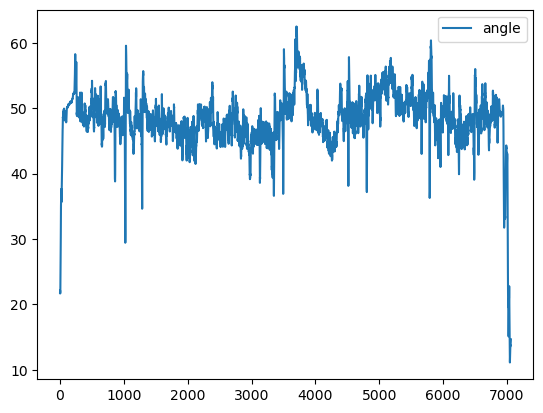

In [10]:
plt.figure()
plt.plot(np.arange(len(df)), df['angle'], label='angle')
plt.legend()
plt.show()

# rotate

In [11]:
def get_rotation_matrix(angle):
    pitch = 0
    roll = angle / 180 * np.pi
    yaw = 0
    p_m = [[np.cos(pitch), 0, np.sin(pitch)], [0, 1, 0], [-np.sin(pitch), 0, np.cos(pitch)]]
    y_m = [[1, 0, 0], [0, np.cos(roll), -np.sin(roll)], [0, np.sin(roll), np.cos(roll)]]
    r_m = [[np.cos(yaw), -np.sin(yaw), 0], [np.sin(yaw), np.cos(yaw), 0], [0, 0, 1]]
    
    p_m, y_m, r_m = np.array(p_m), np.array(y_m), np.array(r_m)
    rotation_matrix = p_m @ y_m @ r_m
    
    return rotation_matrix

In [12]:
def calculate_transform(row, column_name):
    R = get_rotation_matrix(row['angle'] - 45)
    new_mag = R @ row[column_name]
    
    return new_mag

In [13]:
def calculate_new_angle(df):
    df['new_acc_t'] = np.sqrt((df['new_acc_x'] ** 2) + (df['new_acc_y'] ** 2) + (df['new_acc_z'] ** 2))
    df[['new_gacc_x', 'new_gacc_y', 'new_gacc_z']] = df[['new_acc_x', 'new_acc_y', 'new_acc_z']].to_numpy() - df[['new_lin_acc_x', 'new_lin_acc_y', 'new_lin_acc_z']].to_numpy()
    df['new_gacc_t'] = np.sqrt((df['new_gacc_x'] ** 2) + (df['new_gacc_y'] ** 2) + (df['new_gacc_z'] ** 2))

    acc_xyz = df[['new_acc_x', 'new_acc_y', 'new_acc_z']].to_numpy()
    acc_t = df['new_acc_t'].to_numpy()
    gacc_t = df['new_gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 2)), gacc_t[:, None]), axis=-1)

    angle = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return angle

In [14]:
def calculate_z_angle(df):
    df['acc_t'] = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
    df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    df['gacc_t'] = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

    acc_xyz = df[['acc_x', 'acc_y', 'acc_z']].to_numpy()
    acc_t = df['acc_t'].to_numpy()
    gacc_t = df['gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 2)), gacc_t[:, None]), axis=-1)

    angle = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return angle

In [15]:
def calculate_y_angle(df):
    df['acc_t'] = np.sqrt((df['acc_x'] ** 2) + (df['acc_y'] ** 2) + (df['acc_z'] ** 2))
    df[['gacc_x', 'gacc_y', 'gacc_z']] = df[['acc_x', 'acc_y', 'acc_z']].to_numpy() - df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z']].to_numpy()
    df['gacc_t'] = np.sqrt((df['gacc_x'] ** 2) + (df['gacc_y'] ** 2) + (df['gacc_z'] ** 2))

    acc_xyz = df[['acc_x', 'acc_y', 'acc_z']].to_numpy()
    acc_t = df['acc_t'].to_numpy()
    gacc_t = df['gacc_t'].to_numpy()
    gacc_xyz = np.concatenate((np.zeros((len(df), 1)), gacc_t[:, None], np.zeros((len(df), 1))), axis=-1)

    angle = np.arccos((np.sum(acc_xyz * gacc_xyz, axis=-1)) / (acc_t *  gacc_t)) / np.pi * 180
    
    return angle

In [16]:
df[['new_acc_x', 'new_acc_y', 'new_acc_z']] = df.apply(lambda x: calculate_transform(x, ['acc_x', 'acc_y', 'acc_z']), axis=1, result_type='expand')
df[['new_lin_acc_x', 'new_lin_acc_y', 'new_lin_acc_z']] = df.apply(lambda x: calculate_transform(x, ['lin_acc_x', 'lin_acc_y', 'lin_acc_z']), axis=1, result_type='expand')

In [17]:
df['z_angle'] = calculate_z_angle(df)
df['y_angle'] = calculate_y_angle(df)
df['angle'] = df['z_angle'] + df['y_angle']

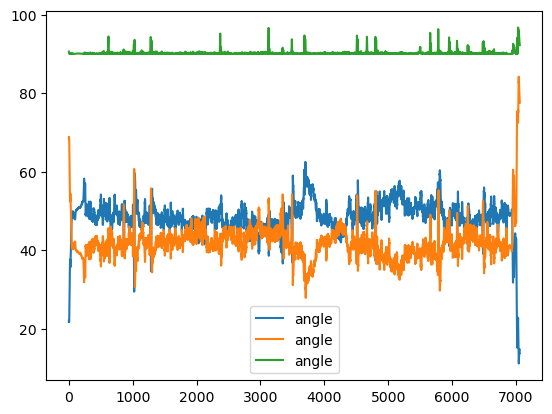

In [18]:
plt.figure()
plt.plot(np.arange(len(df)), df['z_angle'], label='angle')
plt.plot(np.arange(len(df)), df['y_angle'], label='angle')
plt.plot(np.arange(len(df)), df['angle'], label='angle')
# plt.plot(np.arange(len(df)), moving_average(df['angle'], 41), label='angle')
plt.legend()
plt.show()

In [19]:
df[['new_x', 'new_y', 'new_z']] = df.apply(lambda x: calculate_transform(x, ['mag_x', 'mag_y', 'mag_z']), axis=1, result_type='expand')

In [20]:
df

,acc_x,acc_y,acc_z,lin_acc_x,lin_acc_y,lin_acc_z,mag_x,mag_y,mag_z,mag_t,...,new_acc_y,new_acc_z,new_lin_acc_x,new_lin_acc_y,new_lin_acc_z,z_angle,y_angle,new_x,new_y,new_z
0,0.832147,3.552209,9.115417,0.082045,-0.084141,-0.055554,45.801444,-34.656105,-10.191958,58.332615,...,6.854275,6.980539,0.082045,-0.099218,-0.017938,21.813384,68.789831,45.801444,-16.963941,-31.892732
1,0.777225,3.573935,8.989191,0.084033,-0.112311,-0.036290,46.014436,-34.200082,-9.707100,58.148101,...,6.785338,6.894764,0.084033,-0.117588,0.010191,22.140142,68.391305,46.014436,-17.030436,-31.206372
2,0.589501,3.564186,9.097038,-0.073838,0.021584,0.018138,46.269567,-33.614423,-9.299601,57.942082,...,6.876778,6.940422,-0.073838,0.027004,0.008101,21.658975,68.645678,46.269567,-17.031584,-30.435788
3,0.520890,3.589043,9.083474,-0.101890,-0.116005,0.048313,46.477448,-33.106227,-8.976558,57.764644,...,6.881445,6.930832,-0.101890,-0.087536,0.090160,21.764727,68.472261,46.477448,-16.939025,-29.827341
4,0.429539,3.584424,9.047401,-0.109501,-0.106967,0.037924,46.652338,-32.684225,-8.638192,57.613519,...,6.864400,6.898085,-0.109501,-0.083314,0.077064,21.752853,68.409461,46.652338,-16.920268,-29.267413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7056,1.416295,1.880376,9.386544,0.058773,-0.180613,-0.027832,-20.960688,-41.532126,-11.198643,47.850575,...,6.436458,7.086257,0.058773,-0.169246,0.068932,14.079016,78.795629,-20.960688,-19.552078,-38.315054
7057,1.394217,1.939857,9.418578,0.088024,-0.170718,-0.019711,-20.763631,-41.662215,-11.272628,47.895101,...,6.484979,7.100542,0.088024,-0.156773,0.070396,14.232255,78.484140,-20.763631,-19.690617,-38.406925
7058,1.372207,1.971768,9.429015,0.088779,-0.125167,-0.041167,-20.626750,-41.765998,-11.304815,47.933915,...,6.510175,7.100128,0.088779,-0.128640,0.028521,14.293311,78.308399,-20.626750,-19.813664,-38.465779
7059,1.338644,2.042271,9.422905,0.047842,-0.081203,-0.087796,-20.501691,-41.844502,-11.347999,47.958927,...,6.538669,7.085748,0.047842,-0.114510,-0.034491,14.528287,77.889107,-20.501691,-19.958625,-38.488864


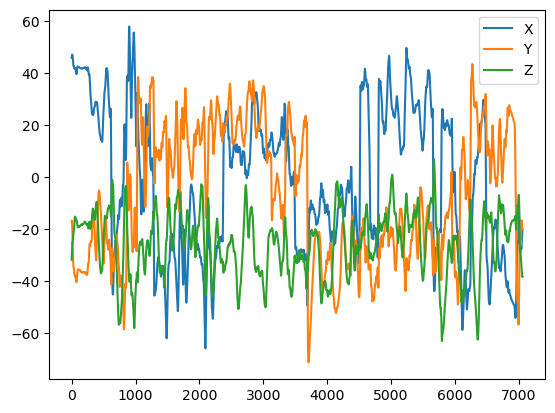

In [21]:
plt.figure()
plt.plot(np.arange(len(df)), df['new_x'], label='X')
plt.plot(np.arange(len(df)), df['new_y'], label='Y')
plt.plot(np.arange(len(df)), df['new_z'], label='Z')

plt.legend()
plt.show()

In [156]:
import matplotlib.pyplot as plt

## eval 1 (平放)

In [315]:
acc_eval = np.array([-0.235394, -0.00927219, 9.95923])
lin_acc_eval = np.array([0.0149174, 0.0154168, 0.0237236])

In [316]:
acc_eval_t = np.sqrt(np.sum(np.power(acc_eval, 2), axis=-1))
acc_eval_t

9.962015785052913

In [317]:
gacc_eval = acc_eval - lin_acc_eval
gacc_eval

array([-0.2503114 , -0.02468899,  9.9355064 ])

In [318]:
gacc_eval_t = np.sqrt(np.sum(np.power(gacc_eval, 2), axis=-1))
gacc_eval_t

9.938689690680464

In [319]:
gacc_eval = np.array([0, 0, gacc_eval_t])
gacc_eval

array([0.        , 0.        , 9.93868969])

In [320]:
angel_eval = np.arccos((acc_eval @ gacc_eval) / (acc_eval_t *  gacc_eval_t)) / np.pi * 180
angel_eval

1.3550269734365894

In [321]:
mag_eval = np.array([17.9438, -20.4000, -70.7813])  # z

In [322]:
mag_eval_t = np.sqrt(np.sum(np.power(mag_eval, 2), axis=-1))
mag_eval_t

75.81643877240607

In [323]:
print(mag_eval_t * np.cos(angel_eval))
print(mag_eval_t * np.sin(angel_eval))

16.232224115631134
74.05840457632019


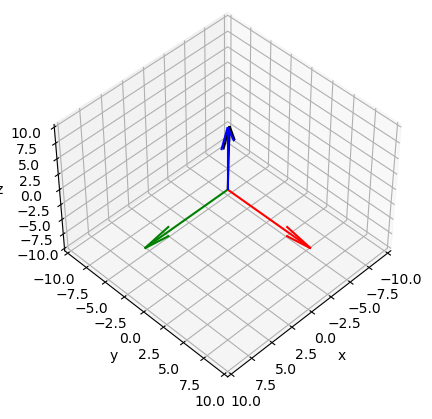

In [257]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# ax.scatter(gacc_eval[0], gacc_eval[1], gacc_eval[2], c='r')
ax.quiver(*[[0], [0], [0]], *gacc_eval, color=['k'])

ax.quiver(*[[0], [0], [0]], *[[10], [0], [0]], color=['g'])
ax.quiver(*[[0], [0], [0]], *[[0], [10], [0]], color=['r'])
ax.quiver(*[[0], [0], [0]], *[[0], [0], [10]], color=['b'])

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(45, 45, 0)  # x, z, y
# ax.axis('equal')

plt.show()

## eval 2 (垂直)

In [305]:
acc_eval = np.array([-0.158824, 9.67957, 0.701097])
lin_acc_eval = np.array([0.0118970, -0.00386429, 0.0309227])

In [306]:
acc_eval_t = np.sqrt(np.sum(np.power(acc_eval, 2), axis=-1))
acc_eval_t

9.706226736033164

In [307]:
gacc_eval = acc_eval - lin_acc_eval
gacc_eval

array([-0.170721  ,  9.68343429,  0.6701743 ])

In [308]:
gacc_eval_t = np.sqrt(np.sum(np.power(gacc_eval, 2), axis=-1))
gacc_eval_t

9.708098624394443

In [309]:
gacc_eval = np.array([0, 0, gacc_eval_t])
gacc_eval

array([0.        , 0.        , 9.70809862])

In [310]:
angel_eval = np.arccos((acc_eval @ gacc_eval) / (acc_eval_t *  gacc_eval_t)) / np.pi * 180
angel_eval

85.85782271599896

In [311]:
mag_eval = np.array([21.3938, -50.0563, -10.9875])  # y

In [312]:
mag_eval_t = np.sqrt(np.sum(np.power(mag_eval, 2), axis=-1))
mag_eval_t

55.534250732138275

In [313]:
print(mag_eval_t * np.cos(angel_eval))
print(mag_eval_t * np.sin(angel_eval))

-28.360218971679394
-47.746737943637534


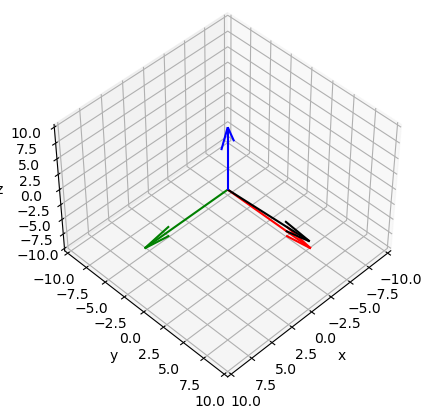

In [261]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# ax.scatter(gacc_eval[0], gacc_eval[1], gacc_eval[2], c='r')
ax.quiver(*[[0], [0], [0]], *gacc_eval, color=['k'])

ax.quiver(*[[0], [0], [0]], *[[10], [0], [0]], color=['g'])
ax.quiver(*[[0], [0], [0]], *[[0], [10], [0]], color=['r'])
ax.quiver(*[[0], [0], [0]], *[[0], [0], [10]], color=['b'])

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# ax.view_init(30, 30, -75)  # x, z, y
ax.view_init(45, 45, 0)
# ax.axis('equal')

plt.show()

## eval3 (橫倒)

In [381]:
acc_eval = np.array([-9.95773, -0.112164, 0.454636])
lin_acc_eval = np.array([0.0210285, -0.0257622, 0.0152515])

In [382]:
acc_eval_t = np.sqrt(np.sum(np.power(acc_eval, 2), axis=-1))
acc_eval_t

9.968734192879856

In [383]:
gacc_eval = acc_eval - lin_acc_eval
gacc_eval

array([-9.9787585, -0.0864018,  0.4393845])

In [384]:
gacc_eval_t = np.sqrt(np.sum(np.power(gacc_eval, 2), axis=-1))
gacc_eval_t

9.988800989668666

In [385]:
gacc_eval = np.array([0, 0, gacc_eval_t])
gacc_eval

array([0.        , 0.        , 9.98880099])

In [386]:
angel_eval = np.arccos((acc_eval @ gacc_eval) / (acc_eval_t *  gacc_eval_t)) / np.pi * 180
angel_eval

87.38605104017311

In [391]:
mag_eval = np.array([60.1688, 0.4500, 17.1750])  # x

In [392]:
mag_eval_t = np.sqrt(np.sum(np.power(mag_eval, 2), axis=-1))
mag_eval_t

62.57369749695154

In [393]:
print(mag_eval_t * np.cos(angel_eval))
print(mag_eval_t * np.sin(angel_eval))

52.39045961739394
-34.21560111291652


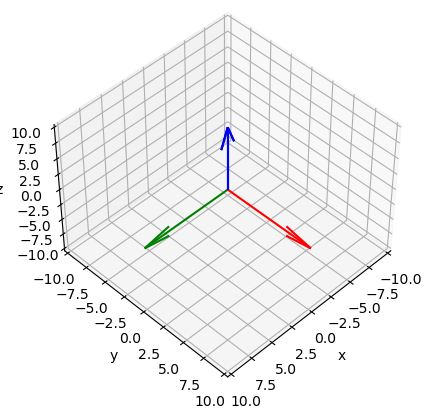

In [390]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# ax.scatter(gacc_eval[0], gacc_eval[1], gacc_eval[2], c='r')
ax.quiver(*[[0], [0], [0]], *gacc_eval, color=['k'])

ax.quiver(*[[0], [0], [0]], *[[10], [0], [0]], color=['g'])
ax.quiver(*[[0], [0], [0]], *[[0], [10], [0]], color=['r'])
ax.quiver(*[[0], [0], [0]], *[[0], [0], [10]], color=['b'])

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)


ax.set_zlim(-10, 10)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# ax.view_init(30, 30, -75)  # x, z, y
ax.view_init(45, 45, 0)
# ax.axis('equal')

plt.show()

# 讀檔

In [3]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path, delimiter):
    time_df = pd.read_csv(path, delimiter=delimiter, index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def gen_total_mag(df: pd.DataFrame):
    
    df['mag_x'] = moving_average(df['mag_x'], 11)
    df['mag_y'] = moving_average(df['mag_y'], 11)
    df['mag_z'] = moving_average(df['mag_z'], 11)
    
    df['mag_t'] = np.sqrt((df['mag_x'] ** 2) + (df['mag_y'] ** 2) + (df['mag_z'] ** 2))
    
    return df


def load_original_data(path, delimiter=';'):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=delimiter)
#     gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=delimiter)
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=delimiter)
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'), delimiter)
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, linacc_df, mag_df], axis=1)
    total_df = total_df[:-5]  # remove last None value row
    total_df = rename_data(total_df)
    total_df = gen_total_mag(total_df)
    total_df = total_df[['acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t', 'system_time']]
    
    return total_df

In [4]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, seq_len=25):
    num_of_segs = int(np.floor(len(df) / seq_len))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * seq_len):int((i + 1) * seq_len)].to_numpy()
        segments.append(seg)
        
    return segments


def split_segments_overlap(df, seq_len=25, shift=15):
    
    segments = []
    for i in range(0, len(df) - seq_len, shift):
        seg = df.iloc[i:i + seq_len].to_numpy()
        segments.append(seg)
        
    return segments


def select_data(df):
    return df[['lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t', 'system_time']]


def preprocess_data(df, seq_len=25, shift=15, is_train_data=False):
    pre_df = select_data(df)
    
    if is_train_data:
        segs = split_segments_overlap(pre_df, seq_len, shift)
    else:
        segs = split_segments(pre_df, seq_len)
    
    return segs

In [5]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

#         print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num, file_index=None, is_train_data=False):
    prefix = 'train' if is_train_data else 'valid'
    pair_data = []
    folder_paths = glob.glob(f'*{os.path.normpath(root_folder)}/*')

    if file_index is not None:
        folder_paths = folder_paths[file_index[0]:file_index[1]]

    for i, folder_path in enumerate(folder_paths):
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(f'{prefix} {i + 1: >3}: {folder_path}')
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        source_df, target_df = align_data(source_df, target_df)

        source_segs = preprocess_data(source_df, seq_len, shift, is_train_data)
        target_segs = preprocess_data(target_df, seq_len, shift, is_train_data)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data